# ***Project work on Painter style recognition, Group 29***
## **Training & Metrics**

Salvatore Grimaldi	0622701742	s.grimaldi29@studenti.unisa.it

Enrico Maria Di Mauro	0622701706	e.dimauro5@studenti.unisa.it

Allegra Cuzzocrea 	0622701707	a.cuzzocrea2@studenti.unisa.it

Andrea De Gruttola	0622701880	a.degruttola@studenti.unisa.it




In [ ]:
#useful imports
from google.colab import drive
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from keras import applications
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import PIL.Image

In [ ]:
# mounting drive and changing path
drive.mount('/content/drive')
%cd drive/MyDrive/29/data/

# path check
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WkiM1CV9ZMwqVumq0o0qMEeIP4UMqwK-/29/data
/content/drive/.shortcut-targets-by-id/1WkiM1CV9ZMwqVumq0o0qMEeIP4UMqwK-/29/data


# Note that everything that concerns Dataset splitting & balancing is in the Colab notebook named `0_DatasetSplitting&Balancing.ipynb` located in `All Colab` folder





# Design Choices
## Splitting
A fundamental task is represented by dataset splitting into two subgroups: training and validation sets. The first one is a data set of examples used during the learning process, while the second one is another set of samples used to provide an unbiased evaluation of the model fit on the training set. It is fundamental that training and validation sets are not related to each other in order to provide a good estimation of network performances.

Since the final private test set is balanced, we decided to obtain a balanced validation set too, even if the original collected dataset was unbalanced. This way, in fact, selecting a model with good performances on average across all classes would have been easier.

First of all, split_data computes the number of samples available for each class, then identifies the less numerous class (which in our case is ‘caravaggio’), computes its val_perc% (which in our case is 360, because we chose to impose val_perc = 20), extracts randomly from this same class a number X of samples corresponding to this percentage and assigns them to the validation set. The remaining part of this class is assigned to the training set. 

After that, the function selects randomly X samples from each of the remaining classes (in our case ‘manet’, ‘vangogh’) and assigns them to the validation set. All the other samples are assigned to the training set. 
In our case the final validation set is composed of 1080 images (360 for each class) and is completely balanced. It is important to observe that the followed procedure implies that inside validation set there are:
-	20% of total number of Caravaggio’s samples
-	15.5% of total number of Manet’s samples
-	8% of total number of Van Gogh’s samples

Although 8% is not a high percentage, it can be assumed that it is a representative set of all Van Gogh’s works for two reasons:
1.	Samples that constitute this percentage were randomly selected
2.	Van Gogh’s style is quite homogeneous since there are no strong stylistic differences within his works

## Training Set Balancing (Oversampling)
First of all, it was considered that the obtained training set was quite unbalanced. Since our purpose was obtaining a model with good performances on average across all classes (in fact we knew that the final private test set that would have been used to evaluate our model was perfectly balanced) we had to choose a strategy to balance the training set. 

An important observation to make is the following one: resampling of data should always be done after splitting data into training and validation sets in order to avoid any kind of correlation between them. In fact, it would negatively affect network performance esteem.

The technique we chose to use is random oversampling: it consists of randomly selecting samples from the minority classes and adding copies of them to the training dataset to get the desired class distribution (in our case 33.3% for each class) before training. It is fundamental to observe that we decided also to use on-the-fly image data augmentation, which ensures that throughout the training the network never sees the exact same sample more than once. This is crucial to avoid overfitting as much as possible.

Oversampling implicitly ensures that all the batches provided to the network during the training are balanced, which is fundamental when (as in our case study) we want to give the exact same importance to all the classes.


In [ ]:
# printing number of samples contained in useful directories
full_data_dir = 'full/'  # directory containing original dataset
train_data_dir = 'train/'  # directory containing training set (after oversampling)
val_data_dir = 'val/'  # directory containing validation set

for sub in os.listdir(full_data_dir):
  if os.path.isdir(os.path.join(full_data_dir, sub)):
    print(sub + " has " + str(len([entry for entry in os.listdir(full_data_dir + sub) if os.path.isfile(os.path.join(full_data_dir + sub, entry))])) + " items")
print('\n')

for sub in os.listdir(train_data_dir):
  if os.path.isdir(os.path.join(train_data_dir, sub)):
    print(sub + " has " + str(len([entry for entry in os.listdir(train_data_dir + sub) if os.path.isfile(os.path.join(train_data_dir + sub, entry))])) + " items")
print('\n')

for sub in os.listdir(val_data_dir):
  if os.path.isdir(os.path.join(val_data_dir, sub)):
    print(sub + " has " + str(len([entry for entry in os.listdir(val_data_dir + sub) if os.path.isfile(os.path.join(val_data_dir + sub, entry))])) + " items")

CARAVAGGIO_CANVA has 56 items
MANET_CANVA has 56 items
VANGOGH_CANVA has 56 items
CARAVAGGIO has 1749 items
MANET has 2318 items
VANGOGH has 4536 items


caravaggio has 4232 items
manet has 4232 items
vangogh has 4232 items


caravaggio has 360 items
manet has 360 items
vangogh has 360 items


In [ ]:
# Printing total number of training and validation samples 
# Assumption: the number of samples for each class after oversampling is the same
train_samples = len([entry for entry in os.listdir('train/caravaggio') if os.path.isfile(os.path.join('train/caravaggio', entry))]) * 3
val_samples = len([entry for entry in os.listdir('val/caravaggio') if os.path.isfile(os.path.join('val/caravaggio', entry))]) * 3

print("After oversampling the total number of training samples is: " + str(train_samples))
print("The total number of validation samples is: " + str(val_samples))

After oversampling the total number of training samples is: 12696
The total number of validation samples is: 1080


# Design Choices
## Data Augmentation
We decided to use image data augmentation to improve the performance and the ability of the model to generalize. Data augmentation is a famous technique to artificially create new training data from existing training samples, which is very useful mostly when the original dataset is not particularly big. Augmenting data grants a broader exploration of the input space and theoretically allows to have infinite samples to submit to the network. For the common case of images, Keras provides ImageDataGenerator, which is a class that can be used to automatically apply a set of image transformations with random parameters in predefined intervals. ImageDataGenerator is particularly useful because it provides the flow_from_directory method, which is used to load training data from the disk and to generate batches with real-time augmentation according to the parameters passed to the ImageDataGenerator constructor. It is important that the applied transformations do not affect the target/label of the images. Moreover, the transformations must be carefully chosen according to the particular classification problem to solve.

Besides, flow_from_directory provides a parameter (target_size) according to which resizing all the images read from disk. Given that the selected network architecture (presented in the next paragraph) has an image input size of 299-by-299, every image was resized to these same dimensions.

The flow_from_directory method was particularly useful for us because it gave us the opportunity to load from the disk small sub-sets of data one after the other, instead of loading in ram the entire training set, which would have been impossible given its huge dimensions.

The transformations that we chose to apply on training samples are the following ones:

-	rescale = 1./255: data normalization is an important step because it ensures that each parameter (pixel in this case) has a similar data distribution. This makes convergence faster while training the network. The applied rescaling technique sets the new range of each sub-pixel to [0-1], in fact the minimum and the maximum acceptable values for each sub-pixel are at the beginning 0 and 255
-	brightness_range = (0.3, 1.3): an important variable to consider when taking a picture (in particular when the subject is a painting) is the environmental light condition. In fact, photos depicting the same subject taken in different times of the day can be characterized by strong differences in terms of brightness. Since we wanted to make our network robust in respect to this, we applied this transformation choosing as bounding parameters values that, looking at the generated samples, seemed to be the most appropriate. Actually, values under 0.3 as lower limit could lead to too dark images, while values over 1.3 as upper limit could lead to too bright images
-	shear_range = 20: since the model must be robust in respect to pictures acquired from different angles, we decided to add this kind of transformation. In fact, it applies a distortion along an axis in order to change the perception angles, which is convenient to simulate photos which depict the same painting from different perspectives. The bound was set to 20 because higher values would have implied too strong distortions
-	rotation_range = 10: real life pictures are characterized by the fact that they are not perfectly horizontally aligned, for this reason considering rotation as a possible transformation is fundamental. Moreover, coupling rotation and shear ensures that a single original image can be seen by the network during the training phase according to a lot of different points of view, which makes the model extremely robust with regard to angles and perspectives. We chose 10 as bound because higher values could lead to unrealistically tilted samples
-	horizontal_flip: given that pictures can be sometimes mirrored (depending on camera settings) we opted for horizontal flip as another possible transformation
-	fill_mode = 'reflect': when applying transformations such as rotations and shears the generated image can show some gaps which must be filled choosing a particular filling strategy. The most appropriate one in our case is represented by ‘reflect’ because all the others imply not realistic generated samples; ‘reflect’, instead, gives life to images which do not risk to confuse the network because the painting is not excessively adulterated.

The transformations applied on validation samples are just:
-	rescale = 1./255
-	resizing to 299x299

They are fundamental to exploit at most what the model learned during the training phase. In fact, a different pre-processing in terms of rescaling and resizing of validation (or test) images could lead to inaccuracies in the evaluation of network performance.
Another important aspect to note is that the randomness with which ImageDataGenerator applies the transformations helps in general to avoid overfitting.

In [ ]:
# This is the preprocessing configuration we will use for training
# On-the-fly augmentation ensures that during training phase the network never sees exactly
# the same image. Moreover, augmentation makes the model more robust
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,  # data normalization makes convergence faster
    brightness_range = (0.3, 1.3),  # environmental light condition is a fundamental variable for photos
    shear_range = 20 , fill_mode = 'reflect',  # photos could be acquired from different angles and points of view
    rotation_range = 10,  # real life pictures are not perfectly horizontally aligned
    horizontal_flip = True)  # pictures can be sometimes mirrored

# this is the preprocessing configuration we will use for validation: rescaling only
val_datagen = ImageDataGenerator(rescale = 1. / 255)

> *Show some augmented examples*




In [ ]:
def generate_plot_pics(datagen,orig_img):
  """
  Generates and prints augmented pics starting from an 'orig_img' and according
  to 'datagen'
  Arguments:
    datagen: ImageDatagenerator according to which performing augmentation
    orig_img: original image
  """
  dir_augmented_data = "preview"
  try:
      # if the preview folder does not exist, create
      os.mkdir(dir_augmented_data)
  except:
      # if the preview folder exists, then remove the contents (pictures) in the folder
      for item in os.listdir(dir_augmented_data):
          os.remove(dir_augmented_data + "/" + item)

  # convert the original image to array
  x = img_to_array(orig_img)
  # reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
  x = x.reshape((1,) + x.shape)

  i = 0
  Nplot = 8
  for batch in datagen.flow(x,batch_size=1,
                        save_to_dir=dir_augmented_data,
                        save_prefix="pic",
                        save_format='jpeg'):
      i += 1
      if i > Nplot - 1:   # generate 8 pictures 
          break

  fig = plt.figure(figsize=(8, 6))
  fig.subplots_adjust(hspace=0.02,wspace=0.01,
                  left=0,right=1,bottom=0, top=1)

  # original picture
  ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
  ax.imshow(orig_img)
  ax.set_title("original")

  i = 2
  for imgnm in os.listdir(dir_augmented_data):
      ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
      img = load_img(dir_augmented_data + "/" + imgnm)
      ax.imshow(img)
      i += 1
  plt.show()

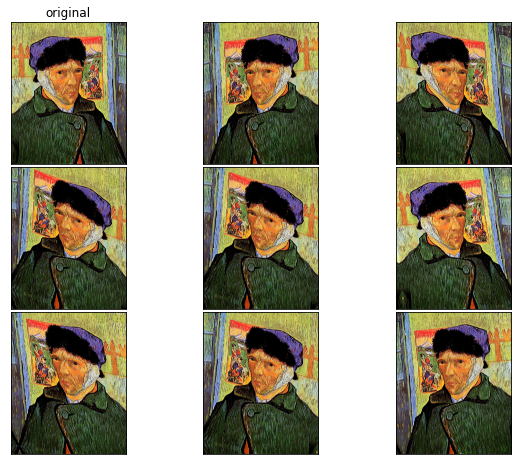

In [ ]:
orig_img = load_img('full/VANGOGH/VANGOGH_252.jpg')
generate_plot_pics(train_datagen, orig_img)

In [ ]:
# resize dimensions of our images for InceptionResNetV2
img_width, img_height = 299, 299

# number of images in a batch
batch_size = 8

print('Training set generator:')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,  # folder containing training samples
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,  # establishing batch size
    class_mode='categorical')  # we are facing a multi-class problem

print('Validation set generator:')
val_generator = val_datagen.flow_from_directory(
    val_data_dir,  # folder containing validation samples
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,  # establishing batch size
    class_mode='categorical')  # we are facing a multi-class problem

Training set generator:
Found 12696 images belonging to 3 classes.
Validation set generator:
Found 1080 images belonging to 3 classes.


# Design Choices
## Network Architecture
The technique we selected is transfer learning because starting from a pre-trained model is a great advantage as it allows us to have a very deep network already trained on a vast dataset. Our aim was to choose an appropriate existing network and to adapt it to our purposes by making small changes to its final part. In most cases the neural networks used for transfer learning are trained on ImageNet (a very large dataset characterized by 1000 different classes) and, therefore, their last layer is made up of 1000 neurons, one for each class of ImageNet. In light of this, it was necessary to replace the last layer of the chosen pre-trained network with a layer made up of just 3 neurons because our classification problem presented just three classes ('caravaggio', 'manet', vangogh').

To select the most appropriate base model we had to make a lot of tests, alternating trainings and validations and using the dataset splitting previously discussed. In particular, among the others, we tested Xception, VGG16, ResNet50, ResNet152, InceptionV3, different versions of EfficientNet and InceptionResNetV2. The latter resulted to be the best one in terms of reached validation accuracy.

InceptionResNetV2 is a non-sequential convolutional neural network trained on ImageNet and characterized by skip connections, normalization layers, blocks with several parallel paths whose outputs are concatenated, which are all useful strategies to reduce vanishing gradient problem without reducing the network length. 

Given that InceptionResNetV2 has an image input size of 299-by-299, we had to adapt all our photos to these dimensions by providing to flow_from_directory method the right target_size parameter: (299, 299).

The reason why transfer learning is so efficient is that the first layers of a good pre-trained network are already able to extract pretty general features that are common to the most of image classification problems, such as shapes, angles, colors, etc. The last layers, instead, are the ones that must be trained more intensely on problem specific data, in fact they have to learn how to extract features related to the specific problem to solve. Moreover, in our specific case, using a network previously trained on ImageNet was particularly useful also because all the investigated artists usually painted lifelike scenes where there were objects that we expect to find in ImageNet.

We even tried to add to the base network other layers (such as convolutional and pooling ones) but without obtaining significant improvements. Moreover, since increasing the complexity of an already very complex network risks to produce overfitting (mostly when the available data is not that much) we decided to abandon this idea.

In [ ]:
model_name = '32_valAcc'

# We use transfer learning and fine tuning
# The base model we selected is InceptionResNetV2 because it gave us the best
# performances during previous tests
base_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

train_aft = (len(base_model.layers))
train_after_layer = train_aft

In [ ]:
# printing base model structure
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                             

In [ ]:
# Visualization of base model: InceptionResNetV2
plot_model(base_model, to_file='inceptionresnetv2_plot.png', dpi=1200, show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# CHANGE THE TOP MODEL BLOCK
# It is necessary to replace the last layer of the chosen pre-trained network
# with a layer made up of just 3 neurons because our classification problem
# presented just three classes ('caravaggio', 'manet', vangogh')

x = base_model.output

# Creation new top layer block
predictions = Dense(units=3, activation='softmax')(x)

# Add new top layer block
model = Model(base_model.input, predictions)

# Design Choices
## Network Training
Given that we had to do with a multi-class classification problem, we decided to use:
-	Softmax as activation function for the output layer

It guarantees that the output of each last layer neuron is between 0 and 1 and that the sum of all last layer neurons outputs is equal to 1. This means that the outputs of the neurons which are part of the output layer can be interpreted as probabilities

-	Categorical cross-entropy as loss function

Which can be seen as a generalization of binary cross-entropy function, that is instead commonly used as loss function in binary classification problems

After few tests we chose Adam as optimization algorithm. We explored also other optimizers such as AdaGrad, RMSProp, SGD with momentum, etc. but the best performances were obtained with Adam. In particular, according to its authors, Adam is able to combine the advantages of AdaGrad and RMSProp and is empirically one of the best algorithms for learning optimization.

Regarding batch size, we made several tests and realized that the best solution for us was 32.

Besides, it is important to remember that when calling the method fit (or fit_generator) on a model with a generator (as we did) Keras has no way of knowing when an epoch is finished because you are not passing the whole training set at once. For this reason, it is compulsory to also provide the steps_per_epochs parameter in order to specify the number of minibatches which constitute a single epoch. Given that in general at the end of every epoch a lot of significant measures (such as accuracy) are performed, and some callbacks could be called, deciding a good epoch size is crucial to determine a correct course of the training. In our case, we set the epoch size equal to the total number of training samples (obtained after oversampling) divided by the batch size. This guaranteed that a single epoch lasted no more than 5-6 minutes, so in case of problems related to the machine or to Colab the amount of “wasted work” would not have been that big.

Choosing the right moment to stop the training in order to avoid overfitting is crucial for obtaining an acceptable model that is capable of generalizing. A good technique that can be easily implemented in Keras to do that is represented by the Early Stopping, which can be considered a particular form of regularization (one of the typical ways through which overfitting can be avoided) and consists of monitoring a network parameter X and stopping the learning procedure when X does not increment anymore after n epochs. Obviously, X and n are hyper-parameters, which means that their choice can affect training and the performances of the final obtained model. As X we chose the validation accuracy because it gives in general a very easy and immediate overview of training, while as n we chose 3 (this parameter in Keras is called patience) because it was neither too high nor too low so it could ensure overfitting limitation without the danger of stopping too early. In fact, it is fundamental to remember that the loss function in general has not a single minimum and its trend can sometimes change. Moreover, it is very useful to save the best weights found so far (even if the learning procedure keeps going): to do that in Keras it is sufficient to use the parameter ModelCheckpoint.

The chosen strategy for the training is the following one.
We decided to split the training in 3 different phases
-	PHASE 1
  -	Only the fully connected last layer is trainable
  -	The maximum number of epochs is set to 30
  -	Learning rate = 10-3
  -	The other Adam parameters are set to default values (β1=0.9, β2=0.999)
-	PHASE 2
  -	All the possible trainable weights are set as trainable
  -	The maximum number of epochs is set to 20
  -	Learning rate = 10-4
  -	The other Adam parameters are set to default values (β1=0.9, β2=0.999)
-	PHASE 3
  -	All the possible trainable weights are set as trainable
  -	The maximum number of epochs is set to 20
  -	Learning rate = 10-5
  -	The other Adam parameters are set to default values (β1=0.9, β2=0.999)

The technique to which the applied strategy is inspired is called fine-tuning.
It is fundamental that the unfreezing of the whole model is performed after that the model with frozen layers has been trained to convergence (at the end of PHASE 1). In fact, if you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. Another thing to notice is that the unfreezing of the whole model is accompanied by a significant reduction of learning rate (PHASE 2 and even more PHASE 3). This is essential to avoid (or reduce) overfitting and to readapt in a slow and incremental way the pretrained weights on the available dataset.

The choice of this particular training strategy was in part inspired by this [paper](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf), which also deals with the problem of artist identification.



> For metrics interpretation check the paragraph `Performance Analysis` in the [report](https://drive.google.com/open?id=12s3v3NmaW7mdB8DdBYycDR-AjPvIoSEv&authuser=e.dimauro5%40studenti.unisa.it&usp=drive_fs)

### PHASE 1

In [ ]:
# We first held the weights of the base InceptionResNetV2 and update only the top dense layer block
for layer in model.layers[:train_after_layer]:
    layer.trainable = False

# Compile the model with Adam optimizer and its default learning rate parameters
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999),                            
              metrics=['accuracy', metrics.TopKCategoricalAccuracy(k=2, name='top_k_categorical_accuracy')])

# Printing network structure 
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_203 (Conv2D)            (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_203 (Batch  (None, None, None,   96         ['conv2d_203[0][0]']             
 Normalization)                 32)                                                         

In [ ]:
epochs = 30   # maximum number of epochs for PHASE 1

h1 = model.fit_generator(
    train_generator, 
    workers = 16,  # useful to accelerate training procedure
    #max_queue_size=16,
    #use_multiprocessing=True,
    steps_per_epoch = (train_samples) // batch_size, 
    epochs = epochs,
    validation_data = val_generator,
    validation_steps = val_samples // batch_size,
    callbacks = [
            ModelCheckpoint('./models/' + model_name + '_intermediate', monitor = 'val_accuracy', save_best_only = True),
            TensorBoard('./logs/' + model_name + '_intermediate'),
            EarlyStopping(monitor = "val_accuracy", patience=3)
            ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
 24/396 [>.............................] - ETA: 5:37 - loss: 0.9348 - accuracy: 0.5586 - top_k_categorical_accuracy: 0.8216

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 633s 2s/step - loss: 0.4615 - accuracy: 0.8227 - top_k_categorical_accuracy: 0.9629 - val_loss: 0.3126 - val_accuracy: 0.8873 - val_top_k_categorical_accuracy: 0.9858
Epoch 2/30
 12/396 [..............................] - ETA: 2:38 - loss: 0.3194 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.9870

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 518s 1s/step - loss: 0.3000 - accuracy: 0.8908 - top_k_categorical_accuracy: 0.9849 - val_loss: 0.2447 - val_accuracy: 0.9129 - val_top_k_categorical_accuracy: 0.9962
Epoch 3/30
 25/396 [>.............................] - ETA: 5:31 - loss: 0.2595 - accuracy: 0.9154 - top_k_categorical_accuracy: 0.9899

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 516s 1s/step - loss: 0.2610 - accuracy: 0.9068 - top_k_categorical_accuracy: 0.9875 - val_loss: 0.2256 - val_accuracy: 0.9195 - val_top_k_categorical_accuracy: 0.9972
Epoch 4/30
 82/396 [=====>........................] - ETA: 5:22 - loss: 0.2352 - accuracy: 0.9190 - top_k_categorical_accuracy: 0.9912

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 452s 1s/step - loss: 0.2385 - accuracy: 0.9150 - top_k_categorical_accuracy: 0.9897 - val_loss: 0.2289 - val_accuracy: 0.9091 - val_top_k_categorical_accuracy: 0.9924
Epoch 5/30
396/396 [==============================] - 519s 1s/step - loss: 0.2191 - accuracy: 0.9202 - top_k_categorical_accuracy: 0.9909 - val_loss: 0.2001 - val_accuracy: 0.9309 - val_top_k_categorical_accuracy: 0.9943
Epoch 6/30
137/396 [=========>....................] - ETA: 4:35 - loss: 0.2152 - accuracy: 0.9231 - top_k_categorical_accuracy: 0.9904

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 464s 1s/step - loss: 0.2068 - accuracy: 0.9257 - top_k_categorical_accuracy: 0.9912 - val_loss: 0.1868 - val_accuracy: 0.9280 - val_top_k_categorical_accuracy: 0.9972
Epoch 7/30
396/396 [==============================] - 463s 1s/step - loss: 0.1912 - accuracy: 0.9341 - top_k_categorical_accuracy: 0.9933 - val_loss: 0.1963 - val_accuracy: 0.9261 - val_top_k_categorical_accuracy: 0.9962
Epoch 8/30
396/396 [==============================] - 463s 1s/step - loss: 0.1863 - accuracy: 0.9322 - top_k_categorical_accuracy: 0.9936 - val_loss: 0.1884 - val_accuracy: 0.9271 - val_top_k_categorical_accuracy: 0.9972


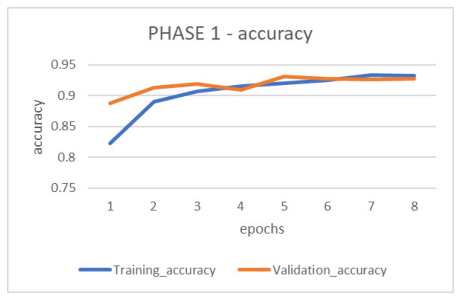

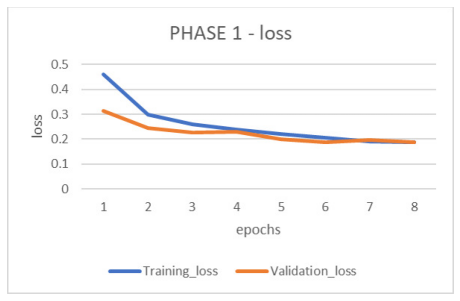

In [ ]:
# Plot accuracy and validation accuracy PHASE 1
a1 = h1.history['accuracy']
va1 = h1.history['val_accuracy']

plt.plot(range(len(a1)),a1, label = 'Training_accuracy')
plt.plot(range(len(a1)),va1, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title("PHASE 1 - accuracy")
plt.legend()
plt.show()

# Plot loss and validation loss PHASE 1
l1 = h1.history['loss']
vl1 = h1.history['val_loss']

plt.plot(range(len(l1)),l1, label = 'Training_loss')
plt.plot(range(len(l1)),vl1, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("PHASE 1 - loss")
plt.legend()
plt.show()

### PHASE 2

In [ ]:
#loading best model from PHASE 1 and making all its layers trainable
model = load_model('./models/' + model_name + '_intermediate')
model.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001,    # reducing by a factor of 10 compared to PHASE 1
                                        beta_1=0.9,
                                        beta_2=0.999),                            
               metrics=['accuracy', metrics.TopKCategoricalAccuracy(k=2, name='top_k_categorical_accuracy')])

#useful to make sure that all the possible trainable parameters are now actually trainable
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
epochs = 20  # maximum number of epochs for PHASE 2

h2 = model.fit_generator(
    train_generator,
    workers=16, # useful to accelerate training procedure
    #max_queue_size=16,
    #use_multiprocessing=True,
    steps_per_epoch=(train_samples) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_samples // batch_size,
     callbacks=[
            ModelCheckpoint('./models/' + model_name + '_finetuned_1', monitor='val_accuracy', save_best_only=True),
            TensorBoard('./logs/' + model_name + '_finetuned_1'),
            EarlyStopping(monitor="val_accuracy", patience=3)
            ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/20
144/396 [=========>....................] - ETA: 5:15 - loss: 0.1509 - accuracy: 0.9450 - top_k_categorical_accuracy: 0.9924

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 624s 1s/step - loss: 0.1015 - accuracy: 0.9663 - top_k_categorical_accuracy: 0.9959 - val_loss: 0.0394 - val_accuracy: 0.9839 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/20
162/396 [===========>..................] - ETA: 4:49 - loss: 0.0196 - accuracy: 0.9929 - top_k_categorical_accuracy: 0.9998

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 526s 1s/step - loss: 0.0257 - accuracy: 0.9905 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.1602 - val_accuracy: 0.9640 - val_top_k_categorical_accuracy: 0.9962
Epoch 3/20
396/396 [==============================] - 597s 1s/step - loss: 0.0262 - accuracy: 0.9915 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.0362 - val_accuracy: 0.9886 - val_top_k_categorical_accuracy: 0.9991
Epoch 4/20
 83/396 [=====>........................] - ETA: 6:13 - loss: 0.0085 - accuracy: 0.9970 - top_k_categorical_accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 598s 1s/step - loss: 0.0144 - accuracy: 0.9953 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.0140 - val_accuracy: 0.9953 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 525s 1s/step - loss: 0.0372 - accuracy: 0.9886 - top_k_categorical_accuracy: 0.9997 - val_loss: 0.0449 - val_accuracy: 0.9839 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/20
396/396 [==============================] - 521s 1s/step - loss: 0.0150 - accuracy: 0.9946 - top_k_categorical_accuracy: 0.9998 - val_loss: 0.0127 - val_accuracy: 0.9953 - val_top_k_categorical_accuracy: 1.0000
Epoch 7/20
396/396 [==============================] - 525s 1s/step - loss: 0.0100 - accuracy: 0.9968 - top_k_categorical_accuracy: 0.9999 - val_loss: 0.0324 - val_accuracy: 0.9924 - val_top_k_categorical_accuracy: 1.0000


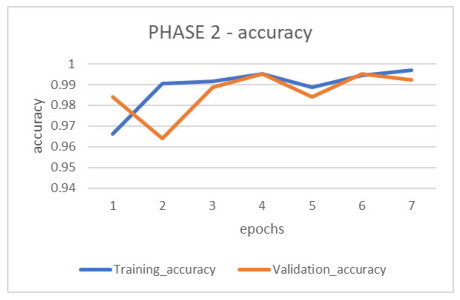

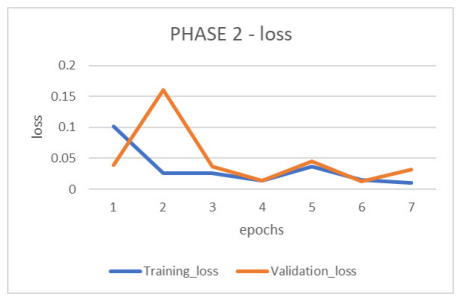

In [ ]:
# Plot accuracy and validation accuracy PHASE 2
a2 = h2.history['accuracy']
va2 = h2.history['val_accuracy']

plt.plot(range(len(a2)),a2, label = 'Training_accuracy')
plt.plot(range(len(a2)),va2, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title("PHASE 2 - accuracy")
plt.legend()
plt.show()

# Plot loss and validation loss PHASE 2
l2 = h2.history['loss']
vl2 = h2.history['val_loss']

plt.plot(range(len(l2)),l2, label = 'Training_loss')
plt.plot(range(len(l2)),vl2, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("PHASE 2 - loss")
plt.legend()
plt.show()

### PHASE 3

In [ ]:
#loading best model from PHASE 2
model = load_model('./models/' + model_name + '_finetuned_1')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001,   # reducing by a factor of 10 compared to PHASE 2
                                        beta_1=0.9,
                                        beta_2=0.999),                            
               metrics=['accuracy', metrics.TopKCategoricalAccuracy(k=2, name='top_k_categorical_accuracy')])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
epochs = 20  # maximum number of epochs for PHASE 3

h3 = model.fit_generator(
    train_generator,
    workers=12,  # useful to accelerate training procedure
    #max_queue_size=10,
    #use_multiprocessing=True,
    steps_per_epoch=(train_samples ) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_samples // batch_size,
     callbacks=[
            ModelCheckpoint('./models/' + model_name + '_finetuned_2', monitor='val_accuracy', save_best_only=True),
            TensorBoard('./logs/' + model_name + '_finetuned_2'),
            EarlyStopping(monitor="val_accuracy", patience=3)
            ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/20
 50/396 [==>...........................] - ETA: 7:03 - loss: 0.0066 - accuracy: 0.9975 - top_k_categorical_accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 636s 2s/step - loss: 0.0040 - accuracy: 0.9987 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 0.9981 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/20
 10/396 [..............................] - ETA: 7:39 - loss: 5.6115e-04 - accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 611s 2s/step - loss: 0.0036 - accuracy: 0.9986 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9991 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/20
146/396 [==========>...................] - ETA: 5:12 - loss: 5.4766e-04 - accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


396/396 [==============================] - 536s 1s/step - loss: 5.9788e-04 - accuracy: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9991 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/20
396/396 [==============================] - 535s 1s/step - loss: 9.4901e-04 - accuracy: 0.9997 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9981 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/20
396/396 [==============================] - 537s 1s/step - loss: 4.4755e-04 - accuracy: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - val_top_k_categorical_accuracy: 1.0000


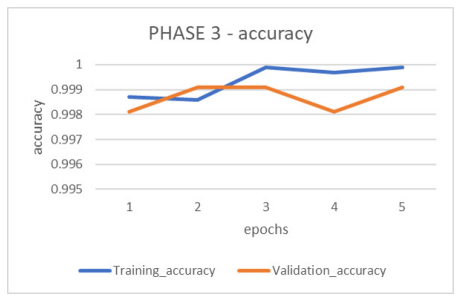

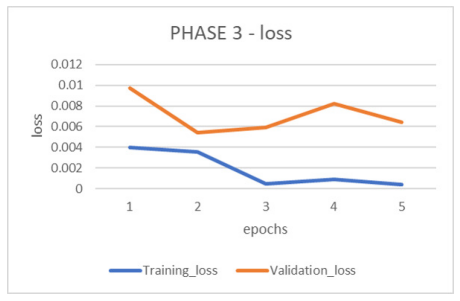

In [ ]:
# Plot accuracy and validation accuracy PHASE 3
a3 = h3.history['accuracy']
va3 = h3.history['val_accuracy']

plt.plot(range(len(a3)),a3, label = 'Training_accuracy')
plt.plot(range(len(a3)),va3, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title("PHASE 3 - accuracy")
plt.legend()
plt.show()

# Plot loss and validation loss PHASE 3
l3 = h3.history['loss']
vl3 = h3.history['val_loss']

plt.plot(range(len(l3)),l3, label = 'Training_loss')
plt.plot(range(len(l3)),vl3, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("PHASE 3 - loss")
plt.legend()
plt.show()

# **Metrics**

In [ ]:
# loading best model from PHASE 3
model = load_model('./models/' + model_name + '_finetuned_2')

In [ ]:
# returning the best metrics values for the best model from PHASE 3
results = model.evaluate_generator(val_generator, val_samples // batch_size)
for i,m in enumerate(model.metrics_names):
  print('\t%s: %f' % (m, results[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


	loss: 0.005297
	accuracy: 0.999074
	top_k_categorical_accuracy: 1.000000


In [ ]:
print('Validation set generator:')
val_generator_bis = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,
    shuffle=False, # useful to use cm_cr function (see next box)
    class_mode='categorical')

Validation set generator:
Found 1080 images belonging to 3 classes.


In [ ]:
# function for computing confusion metrix and classification report
def cm_cr(test_gen, model):
    """
    Computes a classification report of 'model' using 'test_gen'
    Arguments:
      test_gen: Generator over test (or validation) samples
      model: model of which the classification report must be computed
    Returns:
      pred_list: the list of the labels predicted by 'model'
      true_list: the list of the actual labels
    """
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys())   # ordered list of class names 
    pred_list=[]    # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return pred_list, true_list

Classification Report:
----------------------
               precision    recall  f1-score   support

  caravaggio       1.00      1.00      1.00       360
       manet       1.00      1.00      1.00       360
     vangogh       1.00      1.00      1.00       360

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080



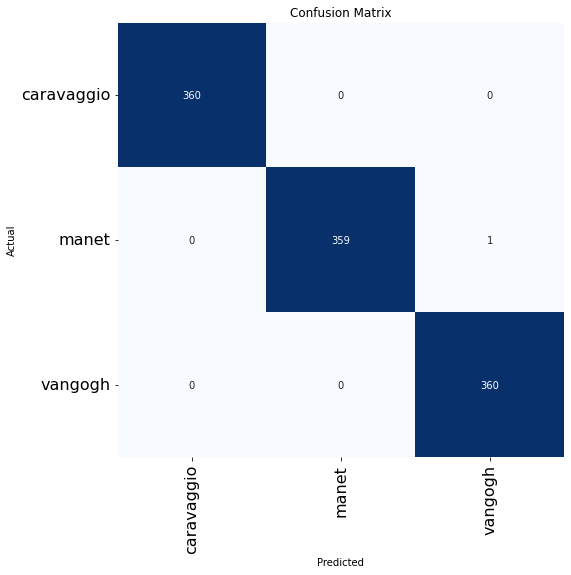

In [ ]:
pred_list, true_list = cm_cr(val_generator_bis, model)  # calling cm_cr

In [ ]:
def non_match_elements(list_a, list_b):
    """
    Determines the indexes where two lists (that are assumed of the same dimension)
    'list_a' and 'list_b' are different.
    Arguments:
      list_a: one of the two lists to be compared
      list_b: one of the two lists to be compared
    Returns:
      non_match: list containing indexes of non-matching elements between 'list_a' and 'list_b'
    """
    non_match = []
    for i in range(len(list_a)):
      if(list_a[i] != list_b[i]):
        non_match.append(i)
    return non_match

In [ ]:
non_match = non_match_elements(pred_list, true_list)  # calling non_match_elements

In [ ]:
fnames = val_generator_bis.filenames    # retrieving all the filenames/samples used in testing
misclassified_samples = []    # list meant to contain all the misclassified samples
for i in non_match:
    print(fnames[i])
    misclassified_samples.append(fnames[i])

manet/MANET_2291.jpg


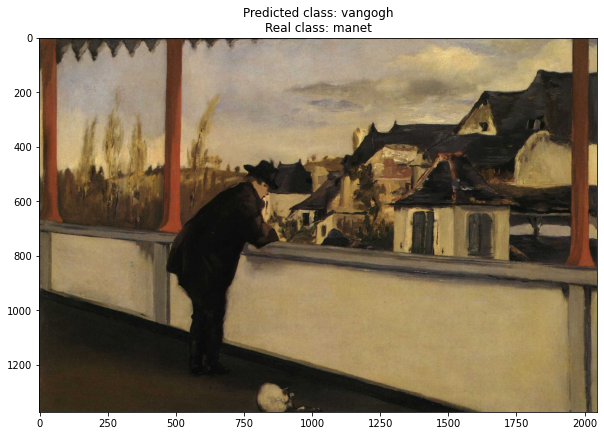

In [ ]:
# Plotting misclassified samples
for i in range(len(non_match)):
  plt.figure()
  plt.imshow(PIL.Image.open('val/' + misclassified_samples[i]))
  plt.title("Predicted class: " + pred_list[non_match[i]] + '\n'+"Real class: " + true_list[non_match[i]])